In [20]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import time

In [21]:
paths = ['dataset/']

In [22]:
def imshow(img):
    fig, ax = plt.subplots(1,1, figsize=(8,8))
    ax.imshow(img, cmap="gray")

In [23]:
possible_labels = os.listdir(os.path.join(paths[0]))
possible_labels.pop(0)
possible_labels

['closed', 'open']

In [24]:
data = []
for i, path in enumerate(paths):
    for label_int, label_string in enumerate(possible_labels):
        filenames = glob.glob(path + label_string + '/*.jpg')
        for filename in filenames:
            img = cv.imread(filename, cv.IMREAD_GRAYSCALE)
            data.append([label_int, cv.resize(img, (224,224))])
print(len(data))

2679


In [26]:
import random
random.Random(0).shuffle(data)

x_train = []
y_train = []
x_test = []
y_test = []

for i, sample in enumerate(data):
    label, img = sample[0], sample[1]
    if i <= 0.7 * len(data):
        x_train.append(img)
        y_train.append(label)
    else:
        x_test.append(img)
        y_test.append(label)

x_train = np.array(x_train)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

In [27]:
x_train = x_train/255
x_test = x_test/255

In [28]:
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [29]:
print(x_train.shape)
print(x_test.shape)

(1876, 224, 224)
(803, 224, 224)


In [30]:
print(y_train.shape)
print(y_test.shape)

(1876, 2)
(803, 2)


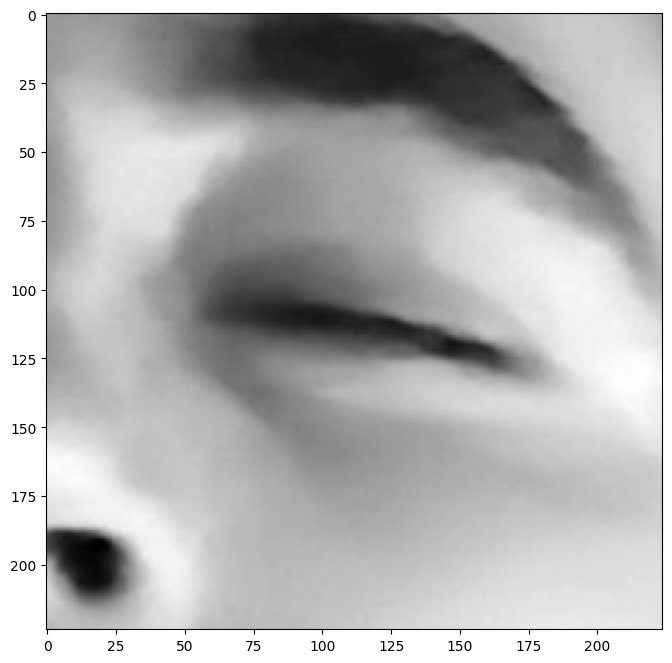

In [31]:
imshow(x_train[0])

# Red neuronal

In [32]:
callback = EarlyStopping(monitor='loss', patience=3)

In [33]:
def model():
    model = Sequential()
    model.add(Conv2D(32,(3,3), input_shape=(224, 224, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Conv2D(32,(3,3), input_shape=(224, 224, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(30, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [34]:
model = model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 72, 72, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 30)             │     1,244,190 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            62 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,253,820 (4.78 MB)

 Trainable params: 1,253,820 (4.78 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
model.fit(x_train, y_train, epochs=10, batch_size=64)

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 247ms/step - accuracy: 0.5361 - loss: 0.7545
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 235ms/step - accuracy: 0.7812 - loss: 0.5255
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 235ms/step - accuracy: 0.9597 - loss: 0.1338
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 238ms/step - accuracy: 0.9817 - loss: 0.0672
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 238ms/step - accuracy: 0.9911 - loss: 0.0361
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 242ms/step - accuracy: 0.9884 - loss: 0.0360
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 253ms/step - accuracy: 0.9967 - loss: 0.0122
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 255ms/step - accuracy: 0.9999 - loss: 0.0084
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 261ms/step - accuracy: 0.9982 - loss: 0.0085
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 266ms/step - accuracy: 0.9983 - loss: 0.0060


In [36]:
model.evaluate(x_test, y_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9958 - loss: 0.0120


[0.007853815332055092, 0.9975093603134155]

In [37]:
p = 1
q = p + 1

for i in range(10):
    prediction = model.predict(x_test[p:q])
    prediction_label = prediction.argmax()
    print(f'Prediction: {prediction_label}')
    print(f'Etiqueta real: {y_test[p].argmax()}')
    p += 1
    q = p+1
    time.sleep(1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction: 0
Etiqueta real: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction: 0
Etiqueta real: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction: 0
Etiqueta real: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction: 1
Etiqueta real: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction: 1
Etiqueta real: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction: 0
Etiqueta real: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction: 1
Etiqueta real: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction: 1
Etiqueta real: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction: 0
Etiqueta real: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction: 0
Etiqueta real: 0


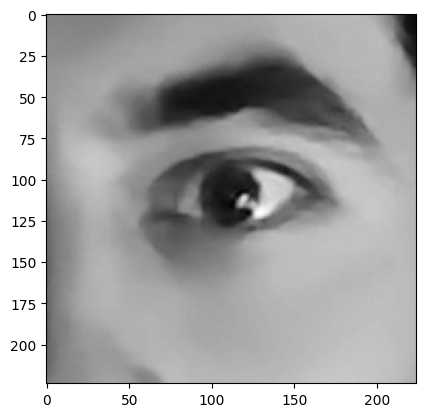

In [38]:
plt.imshow(x_test[p], cmap='gray')

In [39]:
model.save("models/open-closed-eyes-v8.h5")